In [1]:
import json

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pydicom

from keras import layers
from keras.applications import DenseNet121, ResNet50V2, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.initializers import Constant
from keras.utils import Sequence
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2

import keras.metrics as M
import tensorflow_addons as tfa
import pickle

from keras import backend as K

import tensorflow as tf
from tensorflow.python.ops import array_ops

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold

import warnings
warnings.filterwarnings(action='once')

In [2]:
BASE_PATH = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'
TRAIN_DIR = 'stage_2_train/'
TEST_DIR = 'stage_2_test/'

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
train_df = pd.read_csv(BASE_PATH + 'stage_2_train.csv')
#sub_df = pd.read_csv(BASE_PATH + 'stage_1_sample_submission.csv')

train_df['id'] = train_df['ID'].apply(lambda st: "ID_" + st.split('_')[1])
train_df['subtype'] = train_df['ID'].apply(lambda st: st.split('_')[2])
#sub_df['filename'] = sub_df['ID'].apply(lambda st: "ID_" + st.split('_')[1] + ".png")
#sub_df['type'] = sub_df['ID'].apply(lambda st: st.split('_')[2])

print(train_df.shape)
train_df.head()

(4516842, 4)


,ID,Label,id,subtype
0,ID_12cadc6af_epidural,0,ID_12cadc6af,epidural
1,ID_12cadc6af_intraparenchymal,0,ID_12cadc6af,intraparenchymal
2,ID_12cadc6af_intraventricular,0,ID_12cadc6af,intraventricular
3,ID_12cadc6af_subarachnoid,0,ID_12cadc6af,subarachnoid
4,ID_12cadc6af_subdural,0,ID_12cadc6af,subdural


In [4]:
train_df = train_df[["id","subtype","Label"]]
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,subtype,Label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [5]:
train_df = pd.pivot_table(train_df,index="id",columns="subtype",values="Label")
train_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [6]:
pivot_df = train_df.copy()
#bad = []
#for index,row in tqdm(pivot_df.iterrows()):
#    f = BASE_PATH+TRAIN_DIR+index+".dcm"
#    dcm = pydicom.dcmread(f)
#    try:
#        d = dcm.pixel_array
#    except:
#        bad.append(index)
pivot_df.drop("ID_6431af929",inplace=True)
#print(bad)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def map_to_gradient(grey_img):
    rainbow_img = np.zeros((grey_img.shape[0], grey_img.shape[1], 3))
    rainbow_img[:, :, 0] = np.clip(4 * grey_img - 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    rainbow_img[:, :, 1] =  np.clip(4 * grey_img * (grey_img <=0.75), 0,1) + np.clip((-4*grey_img + 4) * (grey_img > 0.75), 0, 1)
    rainbow_img[:, :, 2] = np.clip(-4 * grey_img + 2, 0, 1.0) * (grey_img > 0) * (grey_img <= 1.0)
    return rainbow_img

def rainbow_window(dcm):
    grey_img = window_image(dcm, 40, 80)
    return map_to_gradient(grey_img)

import cupy as cp

def sigmoid_window(dcm, window_center, window_width, U=1.0, eps=(1.0 / 255.0)):
    img = dcm.pixel_array
    img = cp.array(np.array(img))
    _, _, intercept, slope = get_windowing(dcm)
    img = img * slope + intercept
    ue = cp.log((U / eps) - 1.0)
    W = (2 / window_width) * ue
    b = ((-2 * window_center) / window_width) * ue
    z = W * img + b
    img = U / (1 + cp.power(np.e, -1.0 * z))
    img = (img - cp.min(img)) / (cp.max(img) - cp.min(img))
    return cp.asnumpy(img)

def sigmoid_bsb_window(dcm):
    brain_img = sigmoid_window(dcm, 40, 80)
    subdural_img = sigmoid_window(dcm, 80, 200)
    bone_img = sigmoid_window(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img

def window_image(dcm, window_center, window_width):
    _, _, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    bone_img = window_image(dcm, 600, 2000)
    
    bsb_img = np.zeros((brain_img.shape[0], brain_img.shape[1], 3))
    bsb_img[:, :, 0] = brain_img
    bsb_img[:, :, 1] = subdural_img
    bsb_img[:, :, 2] = bone_img
    return bsb_img
    
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

/opt/conda/lib/python3.7/site-packages/cupy/_environment.py:265: ResourceWarning: unclosed file <_io.TextIOWrapper name='/opt/conda/lib/python3.7/site-packages/cupy/.data/_wheel.json' mode='r' encoding='UTF-8'>
  _preload_config = json.load(open(config_path))
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
def preprocess(file,type="WINDOW"):
    dcm = pydicom.dcmread(BASE_PATH+TRAIN_DIR+file+".dcm")
    if type == "WINDOW":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        w = window_image(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "SIGMOID":
        window_center , window_width, intercept, slope = get_windowing(dcm)
        test_img = dcm.pixel_array
        w = sigmoid_window(dcm, window_center, window_width)
        win_img = np.repeat(w[:, :, np.newaxis], 3, axis=2)
        #return win_img
    elif type == "BSB":
        win_img = bsb_window(dcm)
        #return win_img
    elif type == "SIGMOID_BSB":
        win_img = sigmoid_bsb_window(dcm)
    elif type == "GRADIENT":
        win_img = rainbow_window(dcm)
        #return win_img
    else:
        win_img = dcm.pixel_array
    resized = cv2.resize(win_img,(224,224))
    return resized

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
class DataLoader(Sequence):
    def __init__(self, dataframe,
                 batch_size,
                 shuffle,
                 classes,
                 input_shape,
                 num_classes=6,
                 steps=None,
                 prep="BSB"):
        
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.classes=classes
        self.current_epoch=0
        self.prep = prep
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=10000, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=10000, replace=True)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            #image = self.preprocessor.preprocess(ident) 
            image = preprocess(ident,self.prep)
            X[idx] = image
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

In [10]:
def DenseNet():
    densenet = DenseNet121(
    weights='imagenet',
    include_top=False)
    return densenet

def Inception():
    incept = InceptionV3(weights="imagenet",include_top=False)
    return incept

def ResNet():
    resnet = ResNet50V2(weights="imagenet",include_top=False)
    return resnet

def get_backbone(name):
    if name == "RESNET":
        return ResNet
    elif name == "DENSE":
        return DenseNet
    elif name == "INCEPT":
        return Inception

def build_model(backbone):
    m = backbone()
    x = m.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(100, activation="relu")(x)
    x = Dropout(0.3)(x)
    pred = Dense(6,activation="sigmoid")(x)
    model = Model(inputs=m.input,outputs=pred)
    return model

In [14]:
train,test = train_test_split(pivot_df,test_size=0.2,random_state=42,shuffle=True)

split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed,shuffle=True).split(np.arange(train.shape[0]), train["any"].values)

train_idx, dev_idx = next(kfold)

#Images Classes with index
train_data = train.iloc[train_idx]
dev_data = train.iloc[dev_idx]


#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)
train_data.head()


(481792, 6)
(120449, 6)


subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_e2da8edbb,0,0,0,0,0,0
ID_816127d14,0,0,0,0,0,0
ID_83b8094dc,0,0,0,0,0,0
ID_a229b0b40,0,0,0,0,0,0
ID_ae74ec0e2,1,0,0,1,0,0


In [15]:
# def casting_focal_loss():
#     def inner_casting(y_true,y_pred):
#         y_true = tf.cast(y_true, tf.float32)
#         y_pred = tf.cast(y_pred, tf.float32)
#         return tfa.losses.SigmoidFocalCrossEntropy(y_true,y_pred)
    

METRICS = ['accuracy','Precision','Recall','AUC']
#LOSS = casting_focal_loss()
#LOSS = 'categorical_crossentropy'
LOSS='binary_crossentropy'
classes=['any','epidural','subdural','intraparenchymal','intraventricular','subarachanoid']

BATCH_SIZE =32
TRAIN_STEPS = 200#(train_data.shape[0] // BATCH_SIZE)
VAL_STEPS = 200#dev_data.shape[0] // BATCH_SIZE
TEST_STEPS=200
EPOCHS = 8

ALPHA = 0.5
GAMMA = 2

LR = 0.0001

PREP = "SIGMOID_BSB"
#for ARCH in ['RESNET','DENSE','INCEPT']:# Set Data Generator for training, testing and validataion.

# Note for testing, set shuffle = false (For proper Confusion matrix)

# Set Data Generator for training, testing and validataion.

# Note for testing, set shuffle = false (For proper Confusion matrix)

train_dataloader = DataLoader(train_data,
                              BATCH_SIZE,
                              shuffle=True,
                              classes=classes,
                              input_shape=(224,224),
                              steps=TRAIN_STEPS,
                              prep=PREP)

dev_dataloader = DataLoader(dev_data, 
                            BATCH_SIZE,
                            shuffle=True,
                            classes=classes,
                            input_shape=(224,224),
                            steps=VAL_STEPS,
                            prep=PREP)

test_dataloader = DataLoader(test,
                             BATCH_SIZE,
                             shuffle=False,
                             classes=classes,
                             input_shape=(224,224),
                             steps=TEST_STEPS,
                             prep=PREP)


    
cpath = "./" + "RESNET" + "_" + PREP + "_" + str(TRAIN_STEPS) + "_" + str(EPOCHS) 

checkpoint = ModelCheckpoint(filepath=cpath + ".model",mode="min",verbose=1,save_best_only=True,save_weights_only=False,period=1)

model = build_model(get_backbone("RESNET"))

#compile the model
model.compile(optimizer=Adam(learning_rate=LR),loss=LOSS,metrics=[METRICS,tfa.metrics.F1Score(num_classes=6, average="micro")])

#Train the model
history = model.fit_generator(generator=train_dataloader,validation_data=dev_dataloader,epochs=EPOCHS,workers=8,callbacks=[checkpoint])

with open(cpath + ".history", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


94674944/94668760 [==============================] - 3s 0us/step


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
201/201 [==============================] - 178s 825ms/step - loss: 0.4461 - accuracy: 0.6135 - precision: 0.4773 - recall: 0.3509 - auc: 0.7467 - f1_score: 0.3609 - val_loss: 0.2833 - val_accuracy: 0.9681 - val_precision: 0.7108 - val_recall: 0.5570 - val_auc: 0.8999 - val_f1_score: 0.4252

Epoch 00001: val_loss improved from inf to 0.28329, saving model to ./RESNET_SIGMOID_BSB_200_8.model
Epoch 2/8
201/201 [==============================] - 167s 822ms/step - loss: 0.3058 - accuracy: 0.7615 - precision: 0.7325 - recall: 0.5446 - auc: 0.8885 - f1_score: 0.4378 - val_loss: 0.2569 - val_accuracy: 0.8758 - val_precision: 0.7862 - val_recall: 0.5404 - val_auc: 0.9183 - val_f1_score: 0.4210

Epoch 00002: val_loss improved from 0.28329 to 0.25688, saving model to ./RESNET_SIGMOID_BSB_200_8.model
Epoch 3/8
201/201 [==============================] - 166s 814ms/step - loss: 0.2790 - accuracy: 0.7559 - precision: 0.7647 - recall: 0.5843 - auc: 0.9072 - f1_score: 0.4389 - val_loss: 0.229

In [16]:
print("Evaluate")
test_prob = model.evaluate(test_dataloader,steps=200)
res = dict(zip(model.metrics_names, test_prob))
print(res)
print(test_prob)

Evaluate


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200/200 [==============================] - 168s 840ms/step - loss: 0.2104 - accuracy: 0.9809 - precision: 0.7970 - recall: 0.7235 - auc: 0.9463 - f1_score: 0.4355
{'loss': 0.21040979027748108, 'accuracy': 0.9809374809265137, 'precision': 0.7969599962234497, 'recall': 0.7234567999839783, 'auc': 0.9462767839431763, 'f1_score': 0.43552878499031067}
[0.21040979027748108, 0.9809374809265137, 0.7969599962234497, 0.7234567999839783, 0.9462767839431763, 0.43552878499031067]


In [17]:
import os
os.environ['WANDB_MODE']="disabled"
from IPython.display import FileLink
import shutil
from shutil import copyfile

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# Clone and install YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%cd ../
import os
os.environ['WANDB_MODE']="disabled"
from IPython.display import FileLink
import shutil
from shutil import copyfile
# Make a directory to copy the best weights file to
if not os.path.exists('/kaggle/working/output'):
    os.mkdir('/kaggle/working/output')
    # Specify the series and plane (only the T1wCE series is currently available in the dataset)
SERIES = 't1wce'
PLANE = 'axial'
# Call the YOLO train script
!python yolov5/train.py --img 512 --batch 32 --epochs 5 --data '/kaggle/input/qureai-headct' --weights yolov5/yolov5s.pt --cache

fatal: destination path 'yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5
ERROR: Could not find a version that satisfies the requirement numpy>=1.22.2
ERROR: No matching distribution found for numpy>=1.22.2
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
/kaggle/working
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
train: weights=yolov5/yolov5s.pt, cfg=, data=/kaggle/input/qureai-headct, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=32, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, 

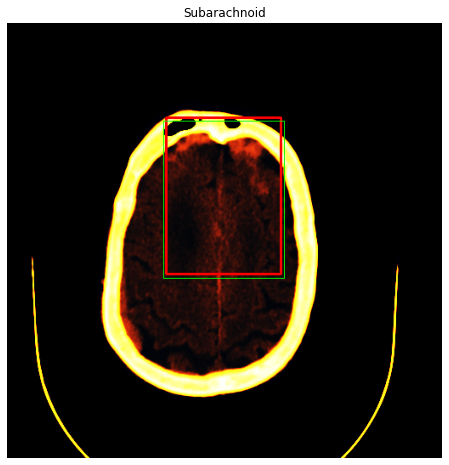

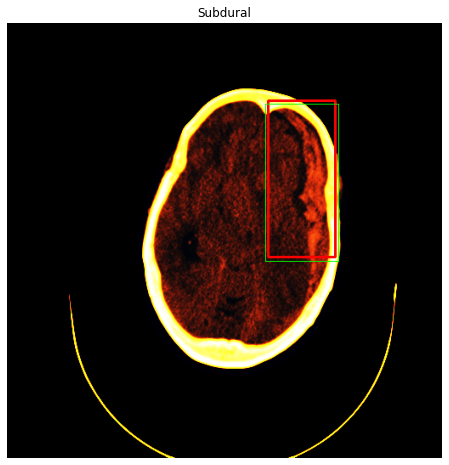

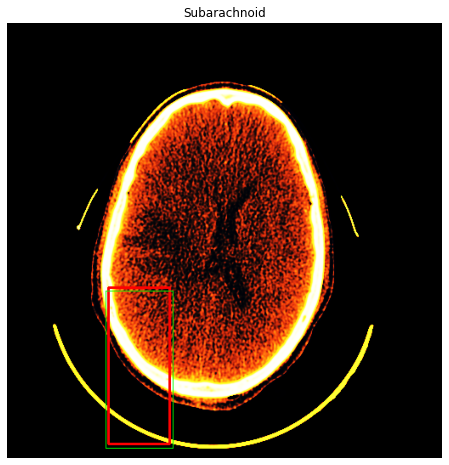

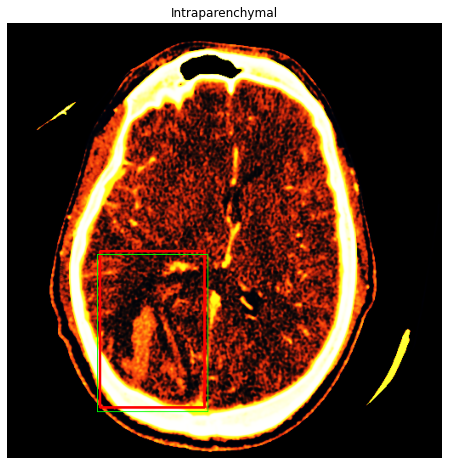

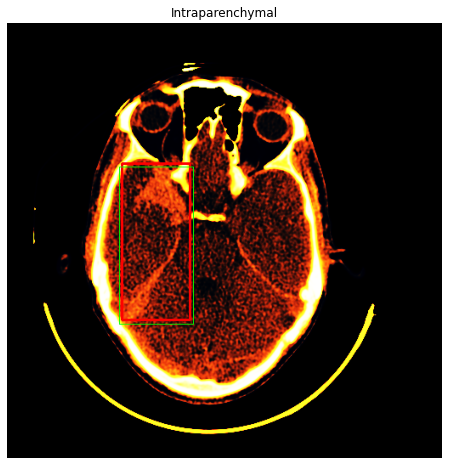

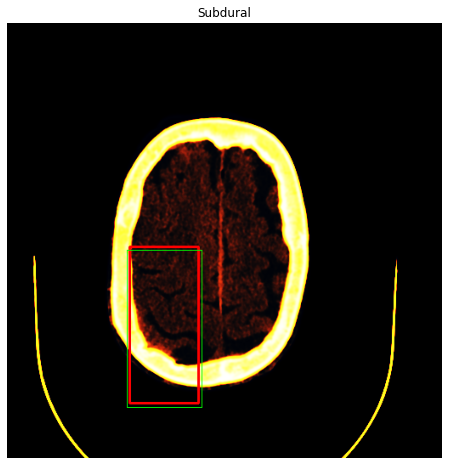

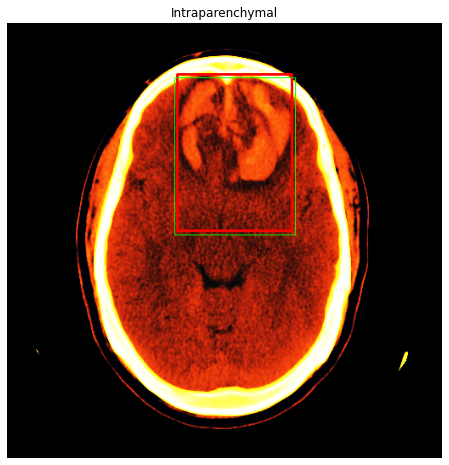

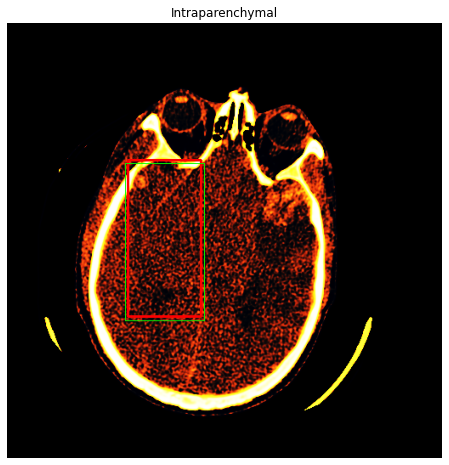

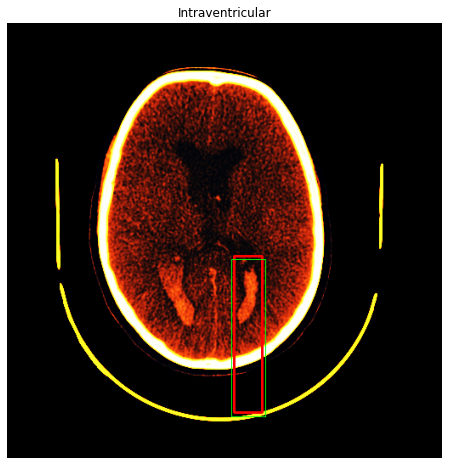

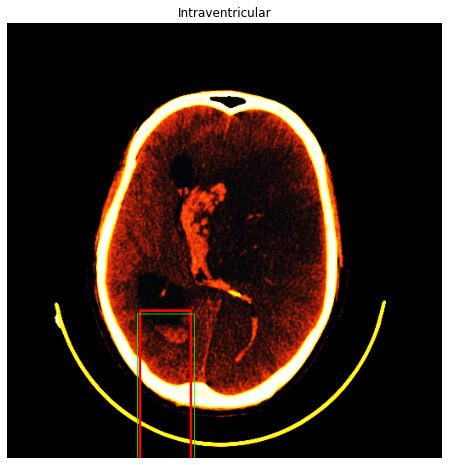

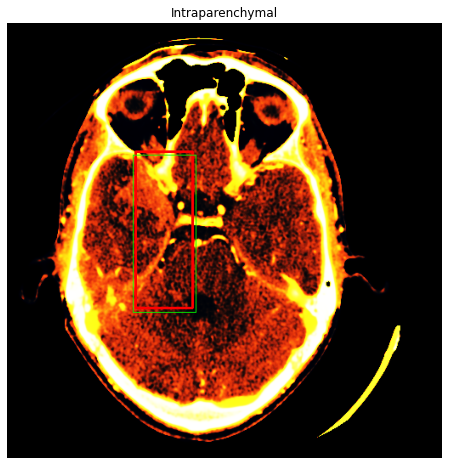

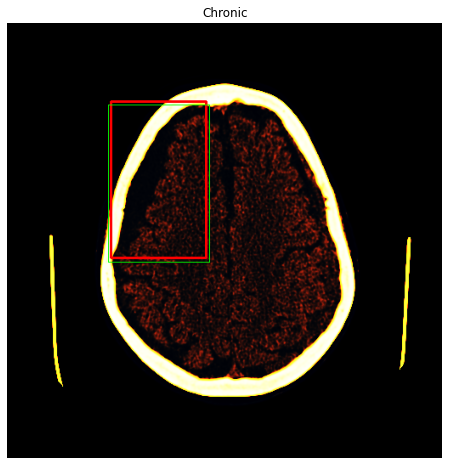

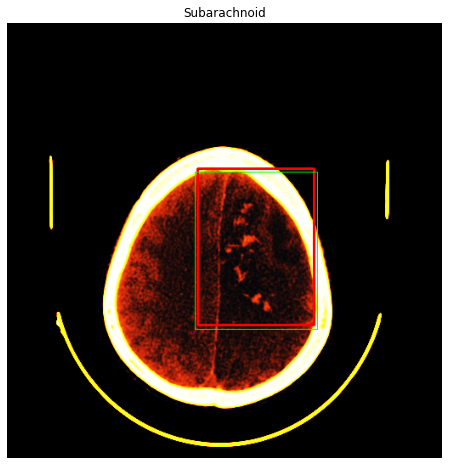

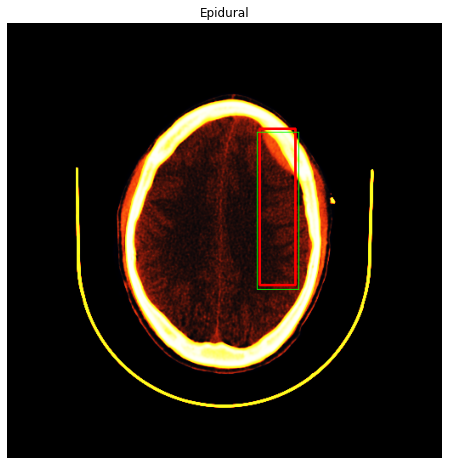

In [38]:
import matplotlib.pyplot as plt
import cv2
import json



for i in range(17):
    try:
        p = ['Image_Path'].iloc[i]  # Get the path to the DICOM image
        k = preprocess(str(p), type="SIGMOID_BSB")  # Preprocess the DICOM image

        label = train_df['labelName'].iloc[i]  # Get the label
        s = train_df['data'].iloc[i]
        bbox_data = json.loads(s.replace("'", "\""))  # Parse bounding box data (assuming it's in JSON format)
        # Extract bounding box coordinates
        x = int(bbox_data['x'])  # Left coordinate
        y = int(bbox_data['y'])  # Top coordinate
        w = int(bbox_data['width'])  # Width
        fig, ax = plt.subplots(figsize=(8, 8)) 
        # Draw the bounding box on the image

        # Display the image with the bounding box
        plt.imshow(k, cmap='gray')
        plt.title(label)  # Set the title to the label
        plt.axis('off')  # Turn off axis labels
        plt.show()
    except Exception as e:
        pass


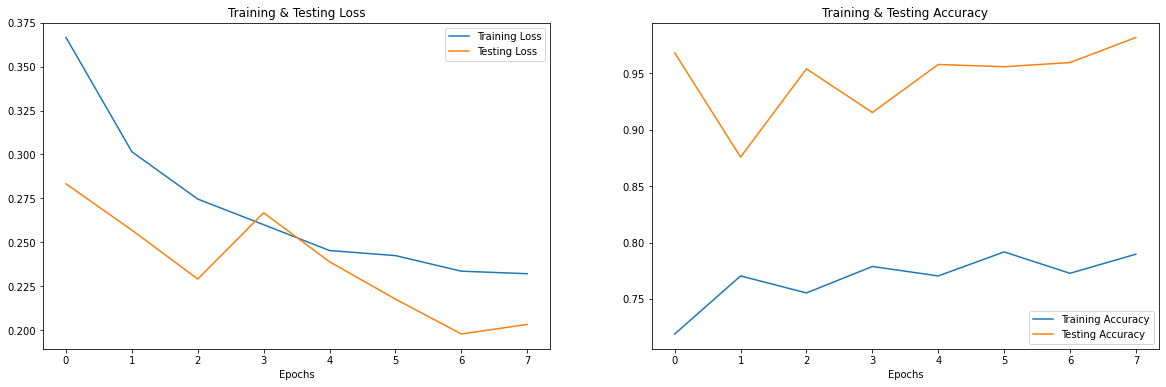

In [41]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()